In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import git
import mlflow.keras
import os, sys
import numpy as np
from gensim.models.wrappers import FastText

import tensorflow_hub as hub
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import *

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline
pd.set_option('display.max_rows', None)

sys.path.append('../citation_bio_trainer')
#from feature.SpacyFeaturizer import get_spacy_feats_from_text
from feature.Featurizer import Featurizer
from util.Utils import calulate_ser_jer, load_from_folder, pad_sequences, load_embedding_matrix, evaluate, log_mlflow_results

In [3]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
path = '/home/joshib/cs_data/citation-bio-labelled-data-2020-06-08~15:13:57.766608/nlp/exps/output/2020-06-08~15:13:57.766608'
#data_df = pd.read_csv(path+'/data-2020-06-08~15:14:01.185827.csv')

## LSTM with random embedding model

In [5]:
%%time
train_data_path = '/nlp/cs_mixed_20k/cs_mixed_20k_train/'
test_data_path  = '/nlp/cs_mixed_20k/cs_mixed_20k_test/'
eval_data_path  = '/nlp/existing_eval_data_with_labels/'
sentences_train, sent_tags_train = load_from_folder(train_data_path)
sentences_test, sent_tags_test = load_from_folder(test_data_path)
sentences_eval, sent_tags_eval = load_from_folder(eval_data_path)

CPU times: user 1min 21s, sys: 666 ms, total: 1min 21s
Wall time: 1min 22s


In [6]:
xtrain, xvalid, ytrain, yvalid = train_test_split(sentences_train, sent_tags_train, test_size=0.1, random_state=42)

In [7]:
%%time
max_vocab = 100000
featurizer = Featurizer(max_vocab=max_vocab, spacy_feats=True)
print("loading train ...")
train_dict, tokenizer, maxlen = featurizer.fit_transform(xtrain, ytrain)
print("loading valid ...")
valid_dict = featurizer.transform(xvalid, yvalid)
print("loading test ...")
test_dict  = featurizer.transform(sentences_test, sent_tags_test)
print("loading eval ...")
eval_dict  = featurizer.transform(sentences_eval, sent_tags_eval)

loading train ...
3861
113.14907002449036
total partitions = 15
loading valid ...
total partitions = 1
loading test ...
total partitions = 1
loading eval ...
total partitions = 1
CPU times: user 7min 57s, sys: 20.6 s, total: 8min 18s
Wall time: 13min 2s


## Keras with pre-trained fast text embedding

In [8]:
%%time
wiki_model = FastText.load_fasttext_format('/nlp/cc.en.300.bin')

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 16s, sys: 3.11 s, total: 2min 19s
Wall time: 2min 36s


In [9]:
%%time
embedding_matrix = load_embedding_matrix(wiki_model, max_vocab, tokenizer.word_index, 300)

Found 2000000 word vectors.
number of null word embeddings: 9769
CPU times: user 7.61 s, sys: 129 ms, total: 7.74 s
Wall time: 7.74 s


In [10]:
# %%time
# model = Sequential()
# model.add(Embedding(max_vocab, 300, weights=[embedding_matrix], trainable=True, input_length= maxlen))
# model.add(LSTM(50, return_sequences=True))
# model.add(TimeDistributed(Dense(1, activation="sigmoid")))
# # model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# model.compile(
#     optimizer=Adam(
#         learning_rate=0.001,
#         beta_1=0.0,
#         beta_2=0.0,
#         epsilon=1e-05,
#         amsgrad=False,
#     ),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [43]:
%%time
input = Input(shape=(maxlen,))
embed = Embedding(input_dim=max_vocab, input_length=maxlen, output_dim=300, weights=[embedding_matrix], trainable=True)(input)
lstm = LSTM(50, return_sequences=True)(embed)
spacy_feats = Input(shape=(maxlen,12))
conc = Concatenate([lstm, spacy_feats])
td = TimeDistributed(Dense(1, activation="sigmoid"))(lstm)
model = Model(inputs=[input, spacy_feats], outputs=td)
model.compile(
    optimizer=Adam(
        learning_rate=0.001,
        beta_1=0.0,
        beta_2=0.0,
        epsilon=1e-05,
        amsgrad=False,
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3861)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 3861, 300)    30000000    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 3861, 50)     70200       embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3861, 12)]   0                                            
____________________________________________________________________________________________

In [44]:
class Metrics(callbacks.Callback):
    def __init__(self, train_data, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_train_begin(self, logs={}):
        self.val_ser = []
        self.val_jer = []
        
    def on_epoch_end(self, epoch, logs):
        vx = self.validation_data[0]
        vy = self.validation_data[1]
        vx = np.array(vx)
        pred_y = None
        pred_y = self.model.predict(vx)
        py = np.argmax(pred_y, axis=-1)
        #vy = np.argmax(vy, axis=-1)
        vy = np.array(vy).flatten()
        py = np.array(py).flatten()
        ser, jer = calulate_ser_jer(vy, py)
        print(ser, jer)
        self.val_ser.append(ser)
        self.val_jer.append(jer)
        logs["val_ser"] = ser
        logs["val_jer"] = jer
        print(f"— val_ser: {ser} — val_jer: {jer}")
        return 

In [45]:
metrics = Metrics([train_dict['lstm_feats'], train_dict['labels']], [valid_dict['lstm_feats'], valid_dict['labels']])

Epoch 1/200
248/248 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.99421.0 1.0
— val_ser: 1.0 — val_jer: 1.0
248/248 [==============================] - 83s 334ms/step - loss: 0.0364 - accuracy: 0.9942 - val_loss: 0.0118 - val_accuracy: 0.9950 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 2/200
248/248 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.99661.0 1.0
— val_ser: 1.0 — val_jer: 1.0
248/248 [==============================] - 82s 331ms/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 0.0068 - val_accuracy: 0.9972 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 3/200
248/248 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.99771.0 1.0
— val_ser: 1.0 — val_jer: 1.0
248/248 [==============================] - 82s 331ms/step - loss: 0.0058 - accuracy: 0.9977 - val_loss: 0.0052 - val_accuracy: 0.9978 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 4/200
248/248 [==============================] - ETA: 0s - loss: 0.0047 - accuracy

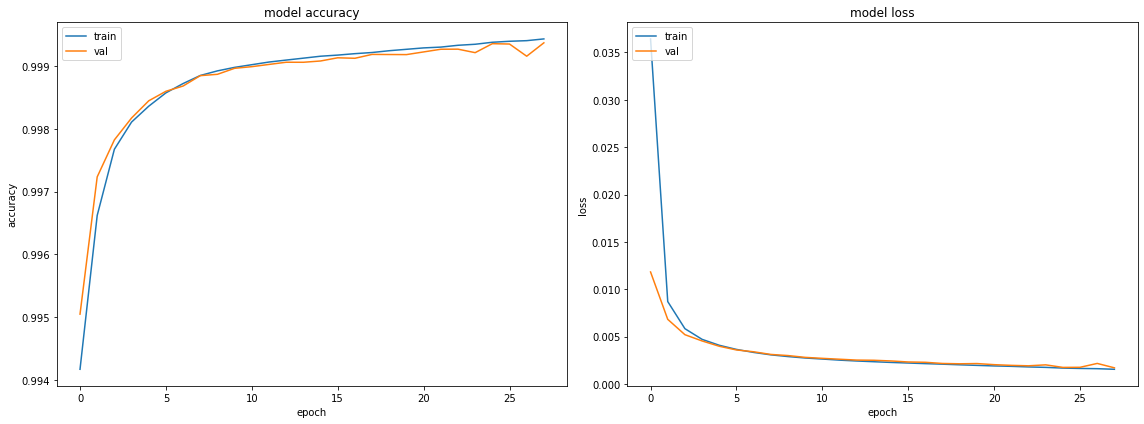

In [46]:
%%time
#spacy_train_arr = np.array([i.tolist() for i in train_dict['spacy_num_feats']])
#spacy_valid_arr = np.array([i.tolist() for i in valid_dict['spacy_num_feats']])
spacy_train_arr = train_dict['spacy_num_feats']
spacy_valid_arr = valid_dict['spacy_num_feats']
early_stop= EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min',restore_best_weights=False, min_delta=0.0001)
history = model.fit([train_dict['lstm_feats'], spacy_train_arr], train_dict['labels'], verbose=1, epochs=200, batch_size= 64, \
                    validation_data=([valid_dict['lstm_feats'], spacy_valid_arr], valid_dict['labels']), callbacks=[early_stop,metrics])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].title.set_text('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].title.set_text('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')
fig.tight_layout()

In [47]:
print('done')

done


### Analysis on validation data

In [48]:
%%time
valid_probs = model.predict([valid_dict['lstm_feats'], valid_dict['spacy_num_feats']])
valid_probs = valid_probs.reshape(valid_probs.shape[0], valid_probs.shape[1])
valid_preds = np.where(valid_probs > 0.5, 1, 0)

CPU times: user 9.42 s, sys: 667 ms, total: 10.1 s
Wall time: 6 s


In [49]:
%%time
result_valid = evaluate(valid_dict['labels'].tolist(), valid_preds.tolist())

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [50]:
result_valid

{'count': 1758,
 'mean_ser': 0.04087086198238625,
 'mean_jer': 0.0677139927271026,
 'mean_acc': 0.9993700312244113,
 'num_mistakes': 1281}

In [21]:
result_valid

{'count': 1758,
 'mean_ser': 0.0033230999769029595,
 'mean_jer': 0.012466057864532192,
 'mean_acc': 0.9999158764801541,
 'num_mistakes': 373}

In [17]:
result_valid

{'count': 1758,
 'mean_ser': 0.01251088985916422,
 'mean_jer': 0.008100913230752143,
 'mean_acc': 0.9998763929366887,
 'num_mistakes': 575}

In [42]:
count_valid = 0
for ind in range(len(valid_preds)):
    pred = valid_preds[ind]
    true = valid_dict['labels'][ind]
    if (true == pred).all():
        pass
    else:
        count_valid += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(fp_ind)
            print(ind, 'False positives:', fp_ind)
            for x in fp_ind:
                #print(x)
                print(np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                print(np.array(xvalid[ind].split(" "))[max(0, x-3):x+4])

8 False positives: [45]
['Com' '.' '\n' '(' '2009' ')' '.']
10 False negatives: [1701]
['2016' '.' '\n' 'ILD' 'Concept' 'Group' ',']
13 False negatives: [449]
['Pilote' 'L.' '\n' 'Premature' 'cardiovascular' 'disease' 'following']
15 False negatives: [196]
['\n' '.' '\n' '.' '\n' '\n' 'Pluhacek']
32 False positives: [201 281 728]
['Youtube' '.' '\n' 'Available' 'at' ':'
 'https://www.youtube.com/user/CDCStreamingHealth']
['3.1' '.' '\n' '<' 'https://eu.idtdna.com/calc/analyzer' '>' '\n']
['stabilized' 'magnetic' '\n' 'skyrmions' ',' 'Nat' 'Commun']
34 False negatives: [228]
['p' '168' '\n' '(' '8)' 'Scheinfein' 'M']
40 False negatives: [357]
['of' 'human' '\n' '10' ')' 'Parkhurst' ',']
41 False negatives: [1575]
['1995;44:219–27' '.' '\n' 'Kasimanickam' 'VR' ',' 'Abdel']
44 False negatives: [1976]
['8' 'May.' '\n' 'VeriFinger' '9.0' '(' '2017']
46 False negatives: [422]
['http://www.nuctech.com' '.' '\n' 'm' ')' 'http://www' '.']
49 False negatives: [168]
['http://www.dreamweaverintl.c

### Analysis of test result

In [24]:
%%time
test_probs = model.predict([test_dict['lstm_feats'], test_dict['spacy_num_feats']])
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[1])
test_preds = np.where(test_probs > 0.5, 1, 0)

CPU times: user 10.2 s, sys: 1.19 s, total: 11.4 s
Wall time: 6.88 s


In [25]:
%%time
result_test = evaluate(test_dict['labels'].tolist(), test_preds.tolist())

CPU times: user 14 s, sys: 26.5 ms, total: 14 s
Wall time: 14 s


In [26]:
result_test

{'count': 1953,
 'mean_ser': 0.0030476776904493448,
 'mean_jer': 0.010335843979169831,
 'mean_acc': 0.9999279891753011,
 'num_mistakes': 379}

In [21]:
result_test

{'count': 1953,
 'mean_ser': 0.011538588904089691,
 'mean_jer': 0.00701819806504542,
 'mean_acc': 0.9998883368058996,
 'num_mistakes': 589}

In [34]:
# tags = {'dataset':'cs_mixed_20k', 'data_split':'test', 'ft':True, 'spacy':True}
# log_mlflow_results(model, result_test, tags)

In [75]:
count = 0
for ind in range(len(test_preds)):
    pred = test_preds[ind]
    true = new_y_test_enc[ind]
    if (true == pred).all():
        pass
    else:
        count += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(fp_ind)
            print(ind, 'False positives:', fp_ind)
            for x in fp_ind:
                #print(x)
                print(np.array(new_X_test[ind])[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                print(np.array(new_X_test[ind])[max(0, x-3):x+4])

2 False positives: [368]
['\n' 'Moroi' '\n' 'Y.' 'Micelles' ':' '\n']
3 False negatives: [1505]
['York' '.' '\n' '.' 'http://www.weizmann.ac.il' '/' 'mcb']
4 False positives: [620]
['065105' '-' '\n' '10' '.' '\n' 'o']
6 False positives: [214]
['CO' '.' '\n' '(' '2009' ')' '.']
16 False positives: [90]
['4' '.' '\n' 'J.' 'Utt' ',' 'R.G.']
16 False negatives: [664]
['Energy' 'Council' '\n' '18' '.' 'Vassilis' 'Daioglou']
21 False positives: [74]
['13' '.' '\n' 'Stanford' ':' 'CSLI' 'pp.29']
26 False positives: [127 168]
['in' 'recent' '\n' 'years' ',' 'see' ':']
['\n' '.' '\n' 'http://www.select.cs.cmu.edu' '/' 'code' '/']
31 False negatives: [254]
[',' 'Tex' '\n' 'Huang' ',' 'A.-B.' '&']
32 False positives: [84]
[';' '2016' '\n' '[' 'accessed' '17.02.02' ']']
33 False positives: [39]
['this' 'does' '\n' 'not' 'provide' 'further' 'clarity']
34 False positives: [351]
['/' 'E8' '\n' 'M' 'Standard' 'Test' 'Methods']
37 False positives: [606]
['Inf' '.' '\n' 'Model' '.' '2016;56:1609–14' '.

### Evaluation of eval dataset

In [44]:
%%time
eval_probs = keras_model.predict(eval_dict['lstm_feats'])
eval_probs = eval_probs.reshape(eval_probs.shape[0], eval_probs.shape[1])
eval_preds = np.where(eval_probs > 0.5, 1, 0)

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


CPU times: user 368 ms, sys: 49.6 ms, total: 417 ms
Wall time: 326 ms


In [45]:
%%time
result_eval = evaluate(eval_dict['labels'].tolist(), eval_preds.tolist())

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 428 ms


In [46]:
result_eval

{'count': 60,
 'mean_ser': 0.13347458546546978,
 'mean_jer': 0.1329170369757607,
 'mean_acc': 0.9981783648450315,
 'num_mistakes': 60}

In [28]:
result_eval

{'count': 60,
 'mean_ser': 0.0,
 'mean_jer': 0.9483493563103681,
 'mean_acc': 0.9941465941465942,
 'num_mistakes': 60}

### Analysis on evaluation set (real-time dataset)

In [ ]:
eval_df = pd.read_csv('/nlp/references_end_to_end_1613_piis_2019-9-13.csv')

In [ ]:
eval_df.head(2)

In [25]:
# %%time
# model = Sequential()
# model.add(Embedding(max_features, embed_size, input_length=maxlen))
# model.add(Bidirectional(LSTM(512, return_sequences=True)))
# #model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(TimeDistributed(Dense(1, activation="sigmoid")))
# # # model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(
#         learning_rate=0.005,
#         beta_1=0.0,
#         beta_2=0.0,
#         epsilon=1e-05,
#         amsgrad=False,
#     ),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [26]:
#model.fit(X_train, y_train, verbose=1, epochs=5, validation_data=(X_test, y_test))

In [74]:
tokenizer.word_index['1']

62

### Analysis on evaluation set (real-time production examples)

In [3]:
eval_df = pd.read_csv("/nlp/references_end_to_end_1613_piis_2019-9-13.csv")

In [4]:
eval_list = eval_df['concatenated_s0_references'].tolist()
sentences_eval = [i.split(" ") for i in eval_list]

In [47]:
#eval_X = [[w for w in s.split(" ")] for s in sentences_eval]
new_eval_X = []
for ind in range(len(sentences_eval)):
    new_seq = []
    for i in range(maxlen):
        try:
            new_seq.append(sentences_eval[ind][i])
        except:
            new_seq.append("PADword")
    new_eval_X.append(new_seq)

In [52]:
X_eval  = np.array(tokenizer.texts_to_sequences(new_eval_X))

In [54]:
eval_probs = model.predict(X_eval)
eval_probs = eval_probs.reshape(eval_probs.shape[0], eval_probs.shape[1])
eval_preds = np.where(eval_probs > 0.5, 1, 0)

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


In [36]:
# import spacy as sp
# from spacy.tokenizer import Tokenizer as sTokenizer
# from spacy.matcher import PhraseMatcher
# import time
# def get_spacy_feats_from_text(textarr):
#     '''
#     This function returns spacy features (categorical and binary separated) when passed list of texts as input. Features are computed for each token(word)
#     '''
#     start_time = time.time()
#     print(textarr.shape)
#     textlist = textarr.tolist()
#     textlist = [t.replace('\n', 'क') for t in textlist] ## as spacy cannot handle consecutive newlines
#     #textlist = [" ".join(i) for i in textls]
#     #print([len(i.split(" ") for i in textlist)])
#     print("after preprocess %0.4f"%(time.time() - start_time))
#     sep = " "
#     text = sep.join(textlist)
#     nlp = sp.load("en_core_web_sm",disable=["parser", "ner", "tokenizer"])
    
#     nlp.tokenizer = sTokenizer(nlp.vocab)
#     print("after tokenizer %0.4f"%(time.time() - start_time))

#     if nlp.max_length < len(text):
#         nlp.max_length = 1 + len(text)
#     rows_token_indexes_in_text = list(np.cumsum([len(a) for a in nlp.tokenizer.pipe(textlist)]))
#     total_tokens = rows_token_indexes_in_text.pop()
#     print(total_tokens)
#     assert(total_tokens == 1 + len(list(nlp.tokenizer.pipe([text]))[0]) ) - len(rows_token_indexes_in_text)

#     def set_custom_boundaries(doc):
#         for token_index in rows_token_indexes_in_text:
#             doc[token_index].is_sent_start = True
#         return doc

#     nlp.add_pipe(set_custom_boundaries, before="tagger")
#     print("before fitting to nlp %0.4f"%(time.time() - start_time))
#     print(text[0:1000])
#     doc = nlp(text)
#     print("after fitting to nlp %0.4f"%(time.time() - start_time))

#     spacy_num_attributes = [ 
#         "IS_ALPHA",  "IS_ASCII", "IS_DIGIT",
#         "IS_LOWER",  "IS_UPPER", "IS_TITLE", 
#         "IS_PUNCT",  "IS_SPACE", "IS_STOP", 
#         "LIKE_NUM",  "LIKE_URL", "LIKE_EMAIL", #"LENGTH",
#     ]
    
#     ## smallint features
#     tokens_features_smallint = doc.to_array(spacy_num_attributes).astype('int8')

#     tokens_features_small =  np.split(tokens_features_smallint,rows_token_indexes_in_text)

#     return np.array(tokens_features_small)

after nlp fit ...after nlp fit ...
after nlp fit ...



/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


after nlp fit ...
after nlp fit ...
after nlp fit ...
after nlp fit ...
after nlp fit ...
after nlp fit ...
after nlp fit ...
after nlp fit ...


In [34]:
import dask.array as da
from feature.SpacyFeaturizer import get_spacy_feats_from_text
def get_spacy_dask(arr):
    dask_arr = da.from_array(arr,chunks=20)
    print(dask_arr)
    dask_out = dask_arr.map_blocks(get_spacy_feats_from_text, dtype='object').compute()
    return dask_out

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
%%time
#bla = get_spacy_dask(np.array(xtrain, dtype='object')[0:1000])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [115]:
for ind in range(10):
    print(len(np.where(bla[ind] == 1)[1]))

16684
7446
5349
14257
39318
16342
6786
14821
9103
13289


In [225]:
len(bla[0]) + len(bla[1])

8361

In [222]:
len(xtrain[0].split(" "))

1179

In [214]:
xtrain[0][0:100]

'1 ) Xu , S. , Liu , H. \n 2011 . New exoelectrogen Citrobacter sp . SX-1 isolated from a microbial fu'

### Load keras models from mlflow

In [12]:
import mlflow
keras_model = mlflow.keras.load_model("s3://caps-s3-mlflow/artifacts/4/1273fe9b942545ce9cf2632f97356bbe/artifacts/models")

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:820: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (isinstance(inputs, collections.Sequence)
/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


In [ ]:
s3://caps-s3-mlflow/artifacts/4/1273fe9b942545ce9cf2632f97356bbe/artifacts/models

In [161]:
x = np.random.rand(6,3)

In [162]:
x

array([[0.38622122, 0.03321862, 0.98188467],
       [0.9751126 , 0.3850725 , 0.89952574],
       [0.42987117, 0.62893666, 0.95506682],
       [0.06800023, 0.91629029, 0.70663666],
       [0.71320144, 0.92170541, 0.1746015 ],
       [0.46984785, 0.98729372, 0.89180675]])

In [163]:
y = np.random.rand(4,3)

In [164]:
y

array([[0.34354131, 0.86629018, 0.61155105],
       [0.97073731, 0.83407179, 0.69913457],
       [0.01072895, 0.63755184, 0.44310931],
       [0.42968261, 0.50313418, 0.22654177]])

In [165]:
x[0:len(y), :] = y[:]

In [166]:
x

array([[0.34354131, 0.86629018, 0.61155105],
       [0.97073731, 0.83407179, 0.69913457],
       [0.01072895, 0.63755184, 0.44310931],
       [0.42968261, 0.50313418, 0.22654177],
       [0.71320144, 0.92170541, 0.1746015 ],
       [0.46984785, 0.98729372, 0.89180675]])

In [189]:
import spacy as sp
import os
os.system('python3 -m spacy download en_core_web_sm')
import numpy as np
import pandas as pd
from spacy.matcher import PhraseMatcher
import dask.dataframe as dd
from dask.multiprocessing import get
from spacy.tokenizer import Tokenizer

def get_array_from_df_combined(df):
    #rows = df.text.apply(lambda x: x.strip()).tolist()
    rows = df.text.tolist()
    rows = [t.replace('\n', 'क') for t in rows] ## as spacy cannot handle consecutive newlines
    sep = " "
    text = sep.join(rows)
    nlp = sp.load("en_core_web_sm", disable=["parser", "ner"])
    nlp.tokenizer = Tokenizer(nlp.vocab)
    

    if nlp.max_length < len(text):
        nlp.max_length = 1 + len(text)
    rows_token_indexes_in_text = list(np.cumsum([len(a) for a in nlp.tokenizer.pipe(rows)]))
    print(rows_token_indexes_in_text)
    total_tokens = rows_token_indexes_in_text.pop()
    #assert(total_tokens == 1 + len(list(nlp.tokenizer.pipe([text]))[0]) ) - len(rows_token_indexes_in_text)

    def set_custom_boundaries(doc):
        for token_index in rows_token_indexes_in_text:
            doc[token_index].is_sent_start = True
        return doc

    nlp.add_pipe(set_custom_boundaries, before="tagger")
    doc = nlp(text)
    #print(len(doc), len(text.split(" ")))
#     spacy_vocab_attributes = [    
#     "ORTH", "LOWER", 
#     "SHAPE",  "LEMMA", 
#     ]

    spacy_vorn_attributes = [    
        "DEP", "POS", "TAG", 
        "ENT_TYPE",
    ]

    spacy_num_attributes = [ 
        "IS_ALPHA",  "IS_ASCII", "IS_DIGIT",
        "IS_LOWER",  "IS_UPPER", "IS_TITLE", 
        "IS_PUNCT",  "IS_SPACE", "IS_STOP", 
        "LIKE_NUM",  "LIKE_URL", "LIKE_EMAIL", #"LENGTH",
    ]
    
    GZT_LISTS = {
    "manuscript_affiliation": [
        "department of", "department for", "faculty of",
        "faculty for", "institute of", "institute for",
        "division for", "division of", "research group",
        "college of", "college for", "laboratory of",
        "laboratory for", "academy of", "academy for",
        "research center", "research centre", "reliability center",
        "centre of", "centre for", "research institute",
        "center of", "center for", "school of",
    ],
    "manuscript_author_degrees_before": [
        "CPT", "Captain", "Colonel (Ret)",
        "Colonel", "Dr.", "Dr", "Mag.",
        "Major", "Mr.", "Mr", "Ms.",
        "Pr.", "Prof.", "Prof", "Professor", "Profs.",
    ],
    "manuscript_section_heading": [
        "Abstract", "Reference", "Keywords",
        "Highlights", "Acknowledgments", "Acknowledgements", 
        "Introduction", "Conclusions",
    ],
    "manuscript_keyword": ["keyword", "key word", "indexed terms"],
    "manuscript_tabfig": ["tab", "fig", "scheme", "box"],
    "manuscript_corresponds": ["correspond"],
    }
    
    ## bigint features
    spacy_bigint_attributes = spacy_vorn_attributes #+ spacy_vocab_attributes
    tokens_features_bigint = doc.to_array(spacy_bigint_attributes).astype('object')
    for i in range(tokens_features_bigint.shape[0]):
        for j in range(tokens_features_bigint.shape[1]):
            tokens_features_bigint[i][j] = nlp.vocab[tokens_features_bigint[i][j]].text
    ## smallint features
    tokens_features_smallint = doc.to_array(spacy_num_attributes).astype('int8')
    ## gzt features
    phrase_matcher = PhraseMatcher(nlp.vocab)
    gzt_attributes = [a.upper() for a in list(GZT_LISTS.keys())]
    gzt_index_map = dict()
    for i, a in enumerate(gzt_attributes):
        gzt_index_map[nlp.vocab.strings[a]] = i 

    gzt_patterns = list()
    for label, terms in GZT_LISTS.items():    
        patterns = [nlp.make_doc(text) for text in terms]
        phrase_matcher.add( label.upper(), None, *patterns)

    gzt_matches = phrase_matcher(doc)

    token_gzt_features = np.zeros(shape=[len(doc),len(gzt_attributes)],dtype="int8")

    for match_id, start, end in gzt_matches:
        gzt_attribute_index = gzt_index_map[match_id]

        span = doc[start:end]
        if span is not None:
            for token in span:
                #print(token.i, token)
                token_gzt_features[ token.i, gzt_attribute_index] = 1
    result_df = pd.DataFrame([])
    tokens_features_small = np.concatenate((tokens_features_smallint, token_gzt_features), axis=1)
    tokens_features_small =  np.split(tokens_features_small,rows_token_indexes_in_text)
        
    tokens_features_big = np.split(tokens_features_bigint,rows_token_indexes_in_text)
    #print(tokens_features_small[0].shape)
    result_df['spacy_bin'] = tokens_features_small
    result_df['spacy_cat'] = tokens_features_big
    return result_df
    
    
    
def get_spacy_dask(df, blocksize=100):
    partitions = 1
    if int(df.shape[0]/ blocksize) > 1:
        partitions = int(df.shape[0]/ blocksize)
    print("total partitions = %d"%partitions)
    spacy_df = dd.from_pandas(df,npartitions=partitions)\
    .map_partitions(get_array_from_df_combined, meta = [('spacy_bin', 'object'), ('spacy_cat', 'object')])\
    .compute(scheduler='processes')
    return spacy_df

In [245]:
train = pd.DataFrame([])
train['text'] = xtrain.copy()

In [246]:
train.shape

(15817, 1)

In [247]:
%%time
from feature.SpacyFeaturizer import SpacyFeaturizer
sp = SpacyFeaturizer()
train_df = sp.get_spacy_dask(train, blocksize=1000)

total partitions = 15
CPU times: user 1.2 s, sys: 3.01 s, total: 4.21 s
Wall time: 1min 40s


In [248]:
for ind in range(len(train_df)):
    if len(xtrain[ind].split(" ")) != len(train_df.spacy_bin.iloc[ind]):
        print(ind)

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
